In [41]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
from collections import namedtuple
from multiprocessing import Pool
from itertools import repeat
import pandas as pd
from jax import random

from definitions import ROOT_DIR
from unc.utils import load_info

plt.rcParams.update({'font.size': 18})

In [42]:
# COLORS

emerald = "#2ecc71"
turquoise = "#1abc9c"
peter_river = "#3498db"
sunflower = "#f1c40f"
alizarin = "#e74c3c"
pumpkin = "#d35400"
green_sea = "#16a085"
wisteria = "#8e44ad"
midnight_blue = "#2c3e50"


all_paths = {
'2': Path(ROOT_DIR, 'results', 'ppo_best', '2_actor_critic'),
'2o':  Path(ROOT_DIR, 'results', 'ppo_best', '2o_actor_critic'),
'2pb': Path(ROOT_DIR, 'results', 'ppo_best', '2pb_actor_critic'),
'2d': Path(ROOT_DIR, 'results', 'ppo_best', '2d_actor_critic')
}



split_by = ['env', 'step_size', 'algo', 'arch', 'n_hidden', 'total_steps']
Args = namedtuple('args', split_by)

plot_path = Path()


def moving_avg(x, mode='valid', w=100):
    return np.convolve(x, np.ones(w), mode=mode) / w

In [43]:
from unc.agents.ppo import PPOAgent
from unc.envs import get_env
agent_path = Path("/Users/ruoyutao/Documents/uncertainty/results/2_actor_critic/f404baae6022440399a0fd9bca03cc1f_Wed Mar 15 18:54:57 2023.pth")
results_path = Path("/Users/ruoyutao/Documents/uncertainty/results/2_actor_critic/f404baae6022440399a0fd9bca03cc1f_Wed Mar 15 18:54:57 2023.npy")
agent = PPOAgent.load(agent_path, PPOAgent)
info = load_info(results_path)

args = agent.args
rng = np.random.RandomState(args.seed)
rand_key = random.PRNGKey(args.seed)

env = get_env(rng, rand_key, args)
all_obs = np.unique(np.array([env.get_obs(state) for state in env.sample_all_states()]), axis=0)
pi, _ = agent.policy(all_obs, agent.actor_network_params)
all_obs, pi.round(2)

/Users/ruoyutao/Documents/uncertainty/venv/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


(array([[0., 0., 1., 0., 0., 1., 0., 1., 0.],
        [0., 0., 1., 0., 0., 1., 1., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 0., 1.],
        [0., 1., 0., 1., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 1., 0., 0., 1.]]),
 Array([[0.        , 0.        , 1.        ],
        [0.98999995, 0.01      , 0.        ],
        [0.        , 0.        , 1.        ],
        [0.        , 1.        , 0.        ],
        [0.41      , 0.59      , 0.        ]], dtype=float32))

In [44]:
def process_dir(dir_path, split_by):
    all_results = {}
        
    for f in tqdm(list(dir_path.iterdir())):
        if not f.is_file() or f.suffix != '.npy':
            continue

        info = load_info(f)
        args = info['args'].item()
        if args['seed'] < 2030:
            continue

        hparams = Args(*tuple(args[s] for s in split_by))

        if hparams not in all_results:
            all_results[hparams] = []

#         all_results[hparams].append((info['episode_reward'], args))
        all_results[hparams].append((args, info['episode_reward'], f))


    
    return all_results

In [35]:
raw_data = {}

for key, v in all_paths.items():
    processed = process_dir(v, split_by)
    
    raw_data[key] = {}
    for hparams, ret in processed.items():
        rew_lst, arg_lst, f_lst = [], [], []
        for r in ret:
            rew_lst.append(r[1])
            arg_lst.append(r[0])
            f_lst.append(r[2])
            rews = np.stack(rew_lst)
        raw_data[key][hparams] = {'rewards': rews, 'args': arg_lst, 'paths': f_lst}
#         print(raw_data[key][hparams]['rewards'].shape)

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

In [36]:
raw_data[key][hparams]['rewards'].shape

(100, 1250)

In [37]:
# Here we get our best hparams
all_best = {}
for key, res in raw_data.items():
    stats_list = []
    for args, rew_dict in res.items():
        # we take mean over both time and seeds
        stats_list.append((args, rew_dict['rewards'].mean(), rew_dict['rewards'], rew_dict['args'], rew_dict['paths']))
    all_best[key] = sorted(stats_list, key=lambda x: x[1])[-1]
for k, v in all_best.items():
    print(k, v[0], v[1])

2 args(env='2', step_size=0.01, algo='ppo', arch='actor_critic', n_hidden=10, total_steps=250000) 16.707328
2o args(env='2o', step_size=0.01, algo='ppo', arch='actor_critic', n_hidden=10, total_steps=250000) 17.711048
2pb args(env='2pb', step_size=0.01, algo='ppo', arch='actor_critic', n_hidden=10, total_steps=250000) 17.105864
2d args(env='2d', step_size=0.01, algo='ppo', arch='actor_critic', n_hidden=10, total_steps=250000) 17.569136


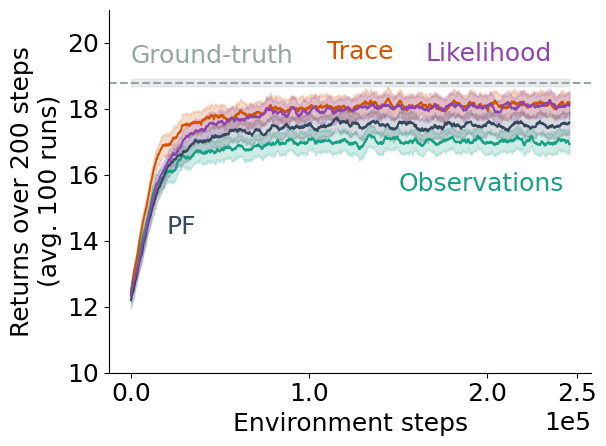

In [54]:
steps_per_eps = 200
plotting_order = ['2', '2o', '2pb', '2d']
lobster_results_path = Path(ROOT_DIR, 'results', f'all_lobster_ppo_results.pdf')
fig, ax = plt.figure(), plt.axes()

plot_info = {
    '2': {
        'color': '#16a085', 
        'label': {'x': 1.5e5, 'y': 15.5, 'text': 'Observations'}
    },
    
    '2o': {
        'color': '#d35400',       
        'label': {'x': 1.1e5, 'y': 19.5, 'text': 'Trace'}
    },
    '2pb': {
        'color': '#34495e', 
        'label': {'x': 0.20e5, 'y': 14.2, 'text': 'PF'}
    },
    '2d': {
        'color': '#8e44ad', 
        'label': {'x': 1.65e5, 'y': 19.45, 'text': 'Likelihood'}
    },

}
for k in plotting_order:
    v = all_best[k]
#     if k not in selection:
#         continue
    data = v[2]
    key = plot_info[k]['label']['text']
    color = plot_info[k]['color']

    means = moving_avg(data.mean(axis=0), w=20, mode='valid')
    x = np.arange(means.shape[0]) * steps_per_eps

    std_err = data.std(axis=0) / np.sqrt(data.shape[0])

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err[:means.shape[0]], means + std_err[:means.shape[0]],
                         color=color, alpha=0.2)
    l_info = plot_info[k]['label']
    plt.text(l_info['x'], l_info['y'], l_info['text'], color=color, fontdict=dict(size=18))

ax.set_ylim(10, 21)

ax.axhline(18.8, linestyle='--', color='#95a5a6')
plt.fill_between(x, 18.8 + 0.112, 18.8 - 0.112, color='#95a5a6', alpha=0.2)
plt.text(0e5, 19.4, 'Ground-truth', color='#95a5a6', fontdict=dict(size=18))


ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Returns over 200 steps\n(avg. 100 runs)")
ax.set_xticks([0, 1e5, 2e5, 2.5e5])


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.tight_layout()
# ax.set_title(f'Lobster Environment')


plt.savefig(lobster_results_path, bbox_inches='tight')
# plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')